In [22]:
# Hybrid ResNet-50 + Transformer Training Notebook
# This notebook trains a hybrid model that combines ResNet-50 backbone 
# with a transformer neck for nodule classification

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import SimpleITK as sitk
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score
import timm
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math

# Import the custom DataHandler
from DataHandler import NoduleDataset

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [23]:
# =============================================================================
# HYBRID MODEL DEFINITION
# =============================================================================

class HybridResNetTransformer(nn.Module):
    """
    Hybrid model combining ResNet-50 backbone with Transformer neck.
    
    Architecture Flow:
    Input (224x224x3) 
    → ResNet-50 backbone → (2048x7x7)
    → 1x1 Conv projection → (256x7x7)
    → Flatten to tokens → (49x256)
    → Add positional encoding
    → Transformer encoder (4 layers) → (49x256)
    → Global average pooling → (256)
    → Classifier head → (num_classes)
    """
    
    def __init__(
        self,
        num_classes=2,
        embed_dim=256,
        num_heads=8,
        num_layers=4,
        mlp_ratio=4.0,
        dropout=0.1,
        pretrained=True
    ):
        super(HybridResNetTransformer, self).__init__()
        
        self.embed_dim = embed_dim
        self.num_layers = num_layers
        
        # 1. ResNet-50 backbone
        resnet = timm.create_model('resnet50', pretrained=pretrained)
        # Remove final pooling and FC layer, keep conv layers
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])
        
        backbone_out_channels = 2048
        
        # 2. Neck: 1x1 conv to reduce channels
        self.channel_proj = nn.Conv2d(
            backbone_out_channels, 
            embed_dim, 
            kernel_size=1, 
            bias=False
        )
        self.channel_norm = nn.BatchNorm2d(embed_dim)
        
        # 3. Positional encoding (learned)
        max_seq_len = 100
        self.pos_embed = nn.Parameter(torch.zeros(1, max_seq_len, embed_dim))
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        
        # 4. Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=int(embed_dim * mlp_ratio),
            dropout=dropout,
            activation='gelu',
            batch_first=True,
            norm_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers,
            norm=nn.LayerNorm(embed_dim)
        )
        
        # 5. Classifier head
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Sequential(
            nn.Linear(embed_dim, embed_dim // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim // 2, num_classes)
        )
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.bias, 0)
                nn.init.constant_(m.weight, 1.0)
    
    def forward(self, x):
        B = x.shape[0]
        
        # Extract features
        features = self.backbone(x)  # (B, 2048, 7, 7)
        
        # Project channels
        features = self.channel_proj(features)  # (B, 256, 7, 7)
        features = self.channel_norm(features)
        
        # Create tokens
        B, C, H, W = features.shape
        N = H * W
        tokens = features.flatten(2).transpose(1, 2)  # (B, 49, 256)
        
        # Add positional encoding
        tokens = tokens + self.pos_embed[:, :N, :]
        
        # Transformer processing
        tokens = self.transformer_encoder(tokens)
        
        # Global pooling and classification
        tokens = self.norm(tokens)
        pooled = tokens.mean(dim=1)
        logits = self.head(pooled)
        
        return logits

In [24]:
# =============================================================================
# CONFIGURATION
# =============================================================================

BATCH_SIZE = 16
NUM_EPOCHS = 25
LEARNING_RATE = 1e-4
IMAGE_SIZE = 224
NUM_WORKERS = 4
WEIGHT_DECAY = 0.01

# Model hyperparameters
EMBED_DIM = 256
NUM_HEADS = 8
NUM_TRANSFORMER_LAYERS = 4
DROPOUT = 0.1

# Paths
split_base_path = "../nodule_dataset21/cxr_images/proccessed_data/split_data"
train_images_path = os.path.join(split_base_path, "train", "images")
val_images_path = os.path.join(split_base_path, "val", "images")
test_images_path = os.path.join(split_base_path, "test", "images")
train_csv_path = os.path.join(split_base_path, "train", "metadata_train.csv")
val_csv_path = os.path.join(split_base_path, "val", "metadata_val.csv")
test_csv_path = os.path.join(split_base_path, "test", "metadata_test.csv")

In [25]:
# =============================================================================
# DATA LOADING
# =============================================================================

# Transforms
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=3),
    transforms.ColorJitter(brightness=0.05, contrast=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load metadata
print("Loading metadata...")
train_df = pd.read_csv(train_csv_path)
val_df = pd.read_csv(val_csv_path)
test_df = pd.read_csv(test_csv_path)

print(f"Train: {len(train_df)} samples")
print(f"Val: {len(val_df)} samples")
print(f"Test: {len(test_df)} samples")

# Create datasets
train_dataset = NoduleDataset(train_df, train_images_path, transform=train_transform)
val_dataset = NoduleDataset(val_df, val_images_path, transform=val_transform)
test_dataset = NoduleDataset(test_df, test_images_path, transform=val_transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                         num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                       num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                        num_workers=NUM_WORKERS, pin_memory=True)

Loading metadata...
Train: 5725 samples
Val: 782 samples
Test: 785 samples


In [26]:
# =============================================================================
# MODEL INITIALIZATION
# =============================================================================

print("\nInitializing Hybrid ResNet-50 + Transformer model...")
model = HybridResNetTransformer(
    num_classes=2,
    embed_dim=EMBED_DIM,
    num_heads=NUM_HEADS,
    num_layers=NUM_TRANSFORMER_LAYERS,
    dropout=DROPOUT,
    pretrained=True
)
model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)


Initializing Hybrid ResNet-50 + Transformer model...


c:\Users\user\Documents\me\Coding\Thesis\.torch\lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
# =============================================================================
# TRAINING FUNCTIONS
# =============================================================================

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    all_probs = []
    
    pbar = tqdm(loader, desc='Training')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        probs = torch.softmax(outputs, dim=1)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs[:, 1].cpu().detach().numpy())
        
        pbar.set_postfix({'loss': running_loss/len(loader), 'acc': 100.*correct/total})
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    epoch_auc = roc_auc_score(all_labels, all_probs)
    epoch_precision = precision_score(all_labels, all_preds, average='binary', zero_division=0)
    
    return epoch_loss, epoch_acc, epoch_auc, epoch_precision, all_preds, all_labels, all_probs


def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc='Validation'):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            probs = torch.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)
            
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    
    binary_precision = precision_score(all_labels, all_preds, average='binary', zero_division=0)
    binary_recall = recall_score(all_labels, all_preds, average='binary', zero_division=0)
    binary_f1 = f1_score(all_labels, all_preds, average='binary', zero_division=0)
    binary_auc = roc_auc_score(all_labels, all_probs)
    
    return epoch_loss, epoch_acc, all_preds, all_labels, all_probs, binary_precision, binary_recall, binary_f1, binary_auc

In [ ]:
# =============================================================================
# TRAINING LOOP
# =============================================================================

print("\nStarting training...")
print("="*70)
print(f"Model: Hybrid ResNet-50 + Transformer")
print(f"Embedding dim: {EMBED_DIM}, Transformer layers: {NUM_TRANSFORMER_LAYERS}, Heads: {NUM_HEADS}")
print("="*70)

history = {
    'train_loss': [], 'train_acc': [], 'train_auc': [], 'train_precision': [],
    'val_loss': [], 'val_acc': [], 'val_auc': [], 'val_precision': []
}

best_val_acc = 0.0
best_model_path = 'best_hybrid_resnet_transformer_model.pth'

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 50)
    
    # Train
    train_loss, train_acc, train_auc, train_precision, train_preds, train_labels, train_probs = train_epoch(
        model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc, val_preds, val_labels, val_probs, val_precision, val_recall, val_f1, val_auc = validate(
        model, val_loader, criterion, device)
    
    # Step scheduler
    scheduler.step()
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['train_auc'].append(train_auc)
    history['train_precision'].append(train_precision)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_auc'].append(val_auc)
    history['val_precision'].append(val_precision)
    
    print(f"Train - Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%, AUC: {train_auc:.4f}, Prec: {train_precision:.4f}")
    print(f"Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%, AUC: {val_auc:.4f}, Prec: {val_precision:.4f}")
    print(f"LR: {optimizer.param_groups[0]['lr']:.6f}")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_auc': val_auc,
        }, best_model_path)
        print(f"✓ Saved best model (Val Acc: {val_acc:.2f}%, Val AUC: {val_auc:.4f})")

print("\n" + "="*70)
print("Training completed!")
print("="*70)


Starting training...
Model: Hybrid ResNet-50 + Transformer
Embedding dim: 256, Transformer layers: 4, Heads: 8

Epoch 1/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:29<00:00,  1.65it/s]



Train - Loss: 0.4733, Acc: 78.03%, AUC: 0.8542, Prec: 0.7799
Val   - Loss: 0.3618, Acc: 83.50%, AUC: 0.9175, Prec: 0.8692
LR: 0.000100
✓ Saved best model (Val Acc: 83.50%, Val AUC: 0.9175)

Epoch 2/25
--------------------------------------------------
✓ Saved best model (Val Acc: 83.50%, Val AUC: 0.9175)

Epoch 2/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:25<00:00,  1.91it/s]



Train - Loss: 0.3219, Acc: 86.78%, AUC: 0.9354, Prec: 0.8783
Val   - Loss: 0.2805, Acc: 87.47%, AUC: 0.9538, Prec: 0.8896
LR: 0.000098
✓ Saved best model (Val Acc: 87.47%, Val AUC: 0.9538)

Epoch 3/25
--------------------------------------------------
✓ Saved best model (Val Acc: 87.47%, Val AUC: 0.9538)

Epoch 3/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:15<00:00,  3.14it/s]



Train - Loss: 0.2526, Acc: 89.66%, AUC: 0.9605, Prec: 0.9020
Val   - Loss: 0.2149, Acc: 90.79%, AUC: 0.9731, Prec: 0.8201
LR: 0.000096
✓ Saved best model (Val Acc: 90.79%, Val AUC: 0.9731)

Epoch 4/25
--------------------------------------------------
✓ Saved best model (Val Acc: 90.79%, Val AUC: 0.9731)

Epoch 4/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:30<00:00,  1.61it/s]



Train - Loss: 0.2084, Acc: 91.84%, AUC: 0.9727, Prec: 0.9224
Val   - Loss: 0.1704, Acc: 93.09%, AUC: 0.9767, Prec: 0.9091
LR: 0.000094
✓ Saved best model (Val Acc: 93.09%, Val AUC: 0.9767)

Epoch 5/25
--------------------------------------------------
✓ Saved best model (Val Acc: 93.09%, Val AUC: 0.9767)

Epoch 5/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:13<00:00,  3.75it/s]


Train - Loss: 0.1938, Acc: 92.54%, AUC: 0.9765, Prec: 0.9299
Val   - Loss: 0.2103, Acc: 91.05%, AUC: 0.9700, Prec: 0.8088
LR: 0.000090

Epoch 6/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:12<00:00,  3.79it/s]



Train - Loss: 0.1674, Acc: 93.52%, AUC: 0.9822, Prec: 0.9401
Val   - Loss: 0.1565, Acc: 93.73%, AUC: 0.9823, Prec: 0.9000
LR: 0.000086
✓ Saved best model (Val Acc: 93.73%, Val AUC: 0.9823)

Epoch 7/25
--------------------------------------------------
✓ Saved best model (Val Acc: 93.73%, Val AUC: 0.9823)

Epoch 7/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:12<00:00,  3.86it/s]


Train - Loss: 0.1449, Acc: 94.57%, AUC: 0.9864, Prec: 0.9460
Val   - Loss: 0.1658, Acc: 92.58%, AUC: 0.9793, Prec: 0.8848
LR: 0.000082

Epoch 8/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:13<00:00,  3.64it/s]



Train - Loss: 0.1319, Acc: 95.06%, AUC: 0.9886, Prec: 0.9534
Val   - Loss: 0.1518, Acc: 93.86%, AUC: 0.9854, Prec: 0.8612
LR: 0.000077
✓ Saved best model (Val Acc: 93.86%, Val AUC: 0.9854)

Epoch 9/25
--------------------------------------------------
✓ Saved best model (Val Acc: 93.86%, Val AUC: 0.9854)

Epoch 9/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:12<00:00,  3.86it/s]



Train - Loss: 0.1163, Acc: 95.20%, AUC: 0.9914, Prec: 0.9552
Val   - Loss: 0.1276, Acc: 94.37%, AUC: 0.9870, Prec: 0.9171
LR: 0.000071
✓ Saved best model (Val Acc: 94.37%, Val AUC: 0.9870)

Epoch 10/25
--------------------------------------------------
✓ Saved best model (Val Acc: 94.37%, Val AUC: 0.9870)

Epoch 10/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:13<00:00,  3.68it/s]


Train - Loss: 0.1185, Acc: 95.70%, AUC: 0.9908, Prec: 0.9562
Val   - Loss: 0.1611, Acc: 93.73%, AUC: 0.9816, Prec: 0.8929
LR: 0.000065

Epoch 11/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:12<00:00,  3.83it/s]


Train - Loss: 0.0970, Acc: 96.49%, AUC: 0.9934, Prec: 0.9642
Val   - Loss: 0.3046, Acc: 89.13%, AUC: 0.9790, Prec: 0.9667
LR: 0.000059

Epoch 12/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:12<00:00,  3.87it/s]


Train - Loss: 0.0930, Acc: 96.59%, AUC: 0.9942, Prec: 0.9666
Val   - Loss: 0.1895, Acc: 94.25%, AUC: 0.9890, Prec: 0.9639
LR: 0.000053

Epoch 13/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:13<00:00,  3.67it/s]


Train - Loss: 0.0768, Acc: 97.21%, AUC: 0.9961, Prec: 0.9718
Val   - Loss: 0.2127, Acc: 93.09%, AUC: 0.9890, Prec: 0.9886
LR: 0.000047

Epoch 14/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:12<00:00,  3.91it/s]



Train - Loss: 0.0709, Acc: 97.34%, AUC: 0.9968, Prec: 0.9706
Val   - Loss: 0.1022, Acc: 95.40%, AUC: 0.9931, Prec: 0.9522
LR: 0.000041
✓ Saved best model (Val Acc: 95.40%, Val AUC: 0.9931)

Epoch 15/25
--------------------------------------------------
✓ Saved best model (Val Acc: 95.40%, Val AUC: 0.9931)

Epoch 15/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:25<00:00,  1.91it/s]


Train - Loss: 0.0638, Acc: 97.90%, AUC: 0.9972, Prec: 0.9791
Val   - Loss: 0.1317, Acc: 95.01%, AUC: 0.9907, Prec: 0.8843
LR: 0.000035

Epoch 16/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:13<00:00,  3.62it/s]



Train - Loss: 0.0636, Acc: 97.57%, AUC: 0.9973, Prec: 0.9784
Val   - Loss: 0.1263, Acc: 96.42%, AUC: 0.9887, Prec: 0.9457
LR: 0.000029
✓ Saved best model (Val Acc: 96.42%, Val AUC: 0.9887)

Epoch 17/25
--------------------------------------------------
✓ Saved best model (Val Acc: 96.42%, Val AUC: 0.9887)

Epoch 17/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:16<00:00,  2.94it/s]


Train - Loss: 0.0547, Acc: 97.96%, AUC: 0.9980, Prec: 0.9791
Val   - Loss: 0.1368, Acc: 95.40%, AUC: 0.9888, Prec: 0.9200
LR: 0.000023

Epoch 18/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:16<00:00,  2.94it/s]


Train - Loss: 0.0431, Acc: 98.39%, AUC: 0.9988, Prec: 0.9824
Val   - Loss: 0.1623, Acc: 94.88%, AUC: 0.9880, Prec: 0.9602
LR: 0.000018

Epoch 19/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:16<00:00,  2.94it/s]


Train - Loss: 0.0544, Acc: 98.01%, AUC: 0.9977, Prec: 0.9807
Val   - Loss: 0.1246, Acc: 95.14%, AUC: 0.9906, Prec: 0.9349
LR: 0.000014

Epoch 20/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:16<00:00,  2.94it/s]


Train - Loss: 0.0376, Acc: 98.67%, AUC: 0.9990, Prec: 0.9868
Val   - Loss: 0.1389, Acc: 95.52%, AUC: 0.9895, Prec: 0.9204
LR: 0.000010

Epoch 21/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:16<00:00,  2.94it/s]


Train - Loss: 0.0423, Acc: 98.45%, AUC: 0.9988, Prec: 0.9864
Val   - Loss: 0.1180, Acc: 95.52%, AUC: 0.9908, Prec: 0.9241
LR: 0.000006

Epoch 22/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:16<00:00,  3.06it/s]


Train - Loss: 0.0424, Acc: 98.60%, AUC: 0.9986, Prec: 0.9846
Val   - Loss: 0.1351, Acc: 95.52%, AUC: 0.9896, Prec: 0.9204
LR: 0.000004

Epoch 23/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:16<00:00,  2.98it/s]


Train - Loss: 0.0410, Acc: 98.67%, AUC: 0.9988, Prec: 0.9874
Val   - Loss: 0.1236, Acc: 95.65%, AUC: 0.9904, Prec: 0.9244
LR: 0.000002

Epoch 24/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:18<00:00,  2.70it/s]


Train - Loss: 0.0354, Acc: 98.78%, AUC: 0.9992, Prec: 0.9881
Val   - Loss: 0.1388, Acc: 94.88%, AUC: 0.9897, Prec: 0.9343
LR: 0.000000

Epoch 25/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:16<00:00,  2.91it/s]

Train - Loss: 0.0407, Acc: 98.60%, AUC: 0.9986, Prec: 0.9862
Val   - Loss: 0.1200, Acc: 95.14%, AUC: 0.9914, Prec: 0.9048
LR: 0.000000

Training completed!


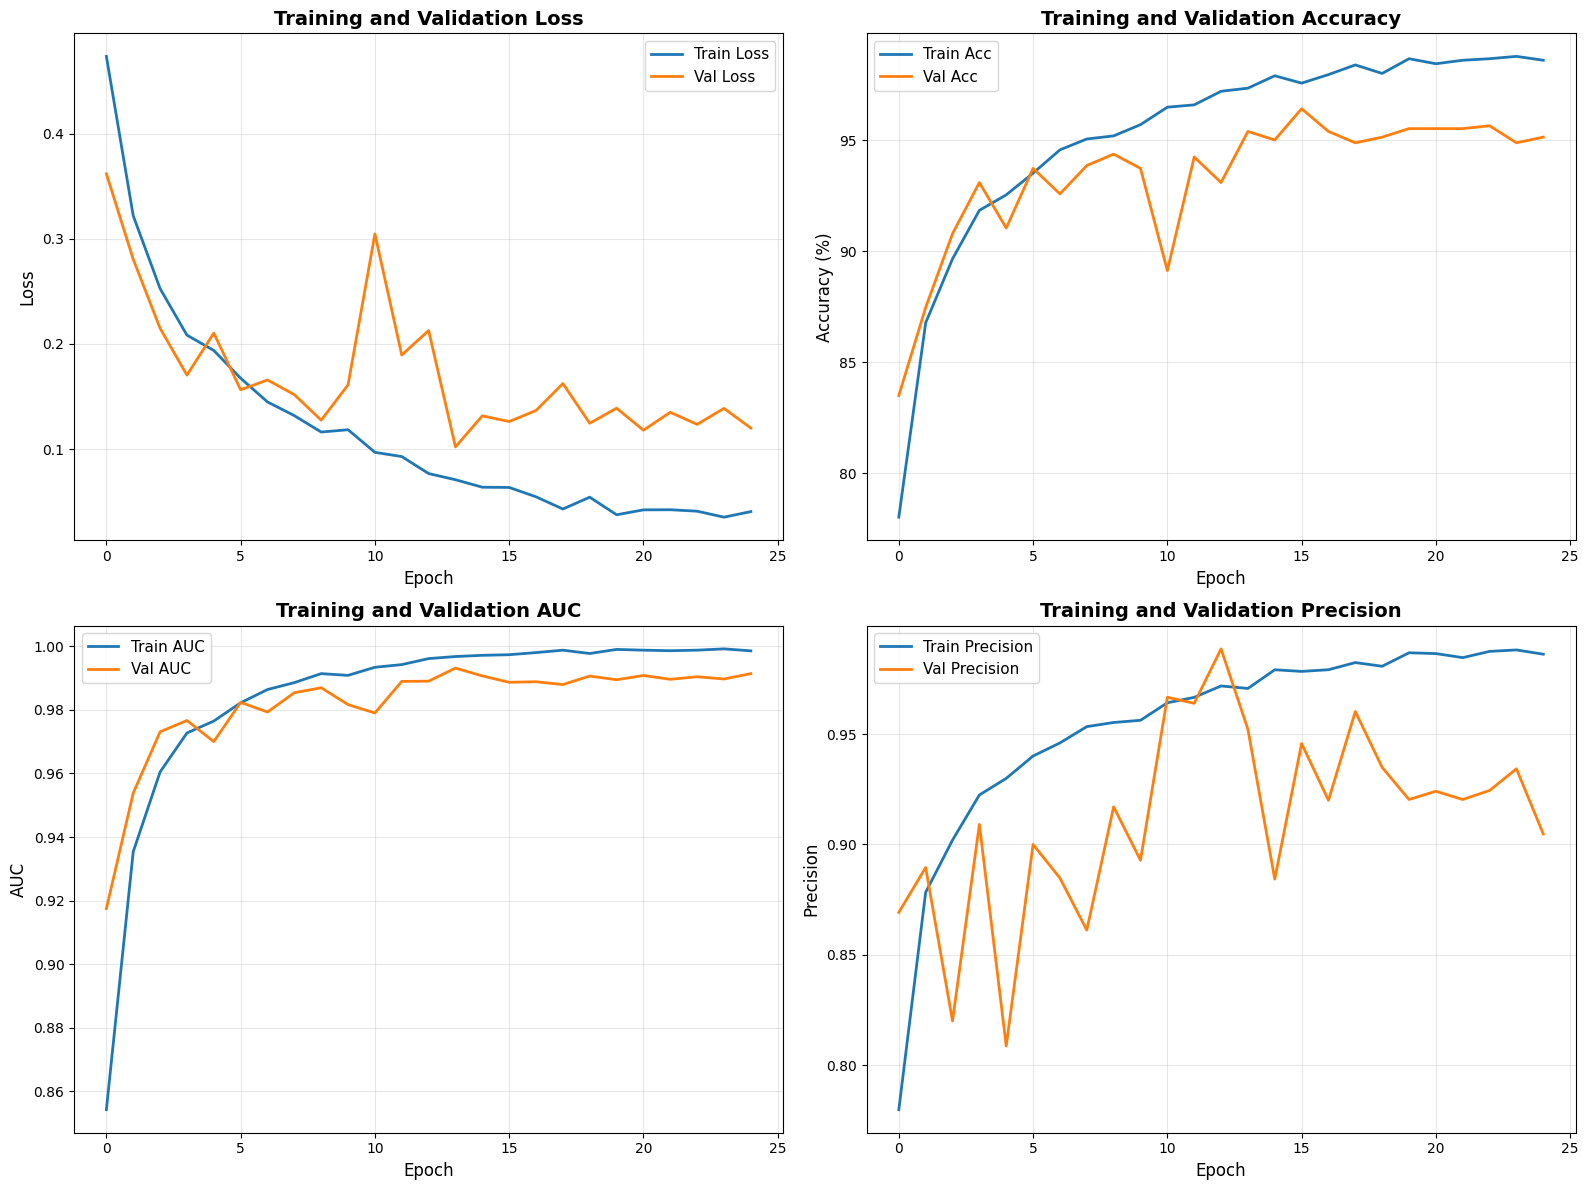

In [ ]:
# =============================================================================
# PLOT TRAINING HISTORY
# =============================================================================

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Loss
ax1.plot(history['train_loss'], label='Train Loss', linewidth=2)
ax1.plot(history['val_loss'], label='Val Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Accuracy
ax2.plot(history['train_acc'], label='Train Acc', linewidth=2)
ax2.plot(history['val_acc'], label='Val Acc', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

# AUC
ax3.plot(history['train_auc'], label='Train AUC', linewidth=2)
ax3.plot(history['val_auc'], label='Val AUC', linewidth=2)
ax3.set_xlabel('Epoch', fontsize=12)
ax3.set_ylabel('AUC', fontsize=12)
ax3.set_title('Training and Validation AUC', fontsize=14, fontweight='bold')
ax3.legend(fontsize=11)
ax3.grid(True, alpha=0.3)

# Precision
ax4.plot(history['train_precision'], label='Train Precision', linewidth=2)
ax4.plot(history['val_precision'], label='Val Precision', linewidth=2)
ax4.set_xlabel('Epoch', fontsize=12)
ax4.set_ylabel('Precision', fontsize=12)
ax4.set_title('Training and Validation Precision', fontsize=14, fontweight='bold')
ax4.legend(fontsize=11)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('hybrid_training_history.png', dpi=150)
plt.show()


Loading best model for testing...


Validation: 100%|██████████| 50/50 [00:12<00:00,  3.99it/s]



TEST SET RESULTS - HYBRID RESNET-50 + TRANSFORMER
Test Results:
Test Loss: 0.1184
Test Accuracy: 94.90%

Classification Report:
              precision    recall  f1-score   support

   No Nodule       0.96      0.97      0.96       568
      Nodule       0.92      0.90      0.91       217

    accuracy                           0.95       785
   macro avg       0.94      0.93      0.94       785
weighted avg       0.95      0.95      0.95       785

Test ROC AUC: 0.9879

Confusion Matrix:
[[550  18]
 [ 22 195]]


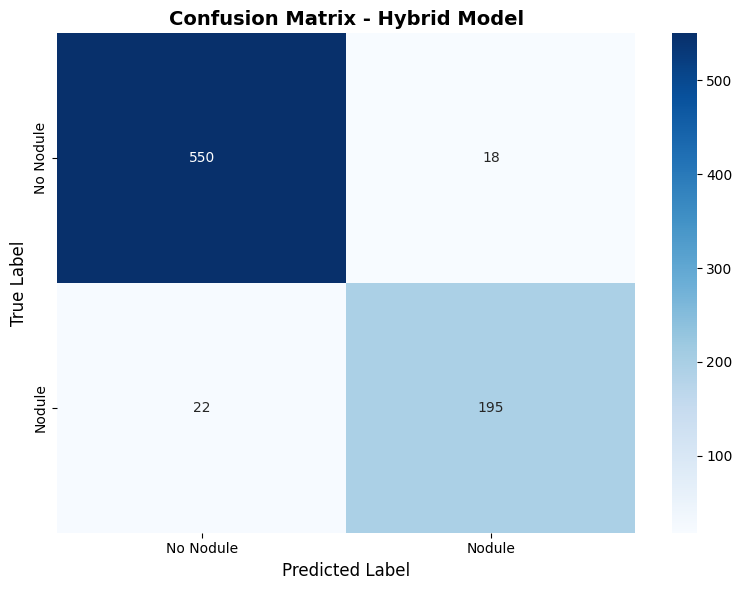


✓ All results saved!


In [27]:
# =============================================================================
# TEST EVALUATION
# =============================================================================

print("\nLoading best model for testing...")
best_model_path = 'best_hybrid_resnet_transformer_model.pth'
model = HybridResNetTransformer(
    num_classes=2,
    embed_dim=EMBED_DIM,
    num_heads=NUM_HEADS,
    num_layers=NUM_TRANSFORMER_LAYERS,
    dropout=DROPOUT,
    pretrained=True
) 
model = model.to(device)
checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint['model_state_dict'])

test_loss, test_acc, test_preds, test_labels, test_probs, test_prec, test_rec, test_f1, test_auc = validate(
    model, test_loader, criterion, device)

print("\n" + "="*70)
print("TEST SET RESULTS - HYBRID RESNET-50 + TRANSFORMER")
print("="*70)
print("Test Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")


# Classification Report
print("\nClassification Report:")
print(classification_report(test_labels, test_preds, target_names=['No Nodule', 'Nodule']))

print(f"Test ROC AUC: {test_auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
print("\nConfusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Nodule', 'Nodule'], 
            yticklabels=['No Nodule', 'Nodule'])
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix - Hybrid Model', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('hybrid_confusion_matrix.png', dpi=300)
plt.show()

print("\n✓ All results saved!")
print("="*70)

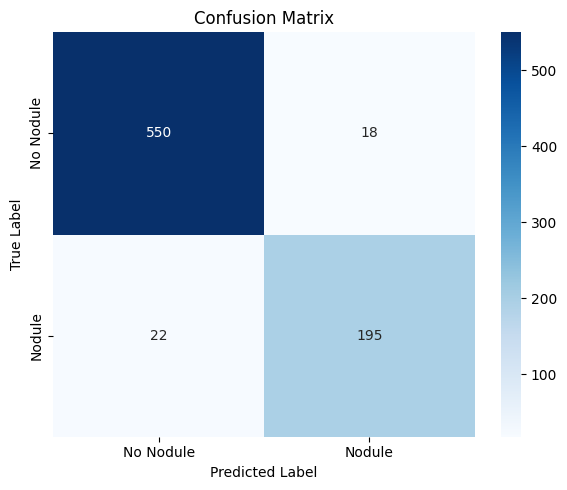

✓ Saved: confusion_matrix.png


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(test_labels, test_preds)
cm_labels = ['No Nodule', 'Nodule']

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cm_labels, yticklabels=cm_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300)
plt.show()
print("✓ Saved: confusion_matrix.png")


In [ ]:
# %% Load Best Model and Evaluate on Test Set
print("\nLoading best model for testing...")
best_model_path = 'best_resnet_nodule_model(NEW).pth'
model = timm.create_model('resnet50', pretrained=False, num_classes=2)
model = model.to(device)
checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint['model_state_dict'])

test_loss, test_acc, test_preds, test_labels, test_probs, test_prec, test_rec, test_f1, test_auc = validate(model, test_loader, criterion, device)

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")
print(f"Test Precision: {test_prec:.4f}")
print(f"Test Recall: {test_rec:.4f}")
print(f"Test F1-score: {test_f1:.4f}")
print(f"Test ROC AUC: {test_auc:.4f}")

print(f"\n" + "="*70)
print("TEST SET RESULTS")
print("="*70)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")

# Classification Report
print("\nClassification Report:")
print(classification_report(test_labels, test_preds, target_names=['No Nodule', 'Nodule']))

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
print("\nConfusion Matrix:")
print(cm)


Loading best model for testing...


RuntimeError: Error(s) in loading state_dict for ResNet:
	Missing key(s) in state_dict: "conv1.weight", "bn1.weight", "bn1.bias", "bn1.running_mean", "bn1.running_var", "layer1.0.conv1.weight", "layer1.0.bn1.weight", "layer1.0.bn1.bias", "layer1.0.bn1.running_mean", "layer1.0.bn1.running_var", "layer1.0.conv2.weight", "layer1.0.bn2.weight", "layer1.0.bn2.bias", "layer1.0.bn2.running_mean", "layer1.0.bn2.running_var", "layer1.0.conv3.weight", "layer1.0.bn3.weight", "layer1.0.bn3.bias", "layer1.0.bn3.running_mean", "layer1.0.bn3.running_var", "layer1.0.downsample.0.weight", "layer1.0.downsample.1.weight", "layer1.0.downsample.1.bias", "layer1.0.downsample.1.running_mean", "layer1.0.downsample.1.running_var", "layer1.1.conv1.weight", "layer1.1.bn1.weight", "layer1.1.bn1.bias", "layer1.1.bn1.running_mean", "layer1.1.bn1.running_var", "layer1.1.conv2.weight", "layer1.1.bn2.weight", "layer1.1.bn2.bias", "layer1.1.bn2.running_mean", "layer1.1.bn2.running_var", "layer1.1.conv3.weight", "layer1.1.bn3.weight", "layer1.1.bn3.bias", "layer1.1.bn3.running_mean", "layer1.1.bn3.running_var", "layer1.2.conv1.weight", "layer1.2.bn1.weight", "layer1.2.bn1.bias", "layer1.2.bn1.running_mean", "layer1.2.bn1.running_var", "layer1.2.conv2.weight", "layer1.2.bn2.weight", "layer1.2.bn2.bias", "layer1.2.bn2.running_mean", "layer1.2.bn2.running_var", "layer1.2.conv3.weight", "layer1.2.bn3.weight", "layer1.2.bn3.bias", "layer1.2.bn3.running_mean", "layer1.2.bn3.running_var", "layer2.0.conv1.weight", "layer2.0.bn1.weight", "layer2.0.bn1.bias", "layer2.0.bn1.running_mean", "layer2.0.bn1.running_var", "layer2.0.conv2.weight", "layer2.0.bn2.weight", "layer2.0.bn2.bias", "layer2.0.bn2.running_mean", "layer2.0.bn2.running_var", "layer2.0.conv3.weight", "layer2.0.bn3.weight", "layer2.0.bn3.bias", "layer2.0.bn3.running_mean", "layer2.0.bn3.running_var", "layer2.0.downsample.0.weight", "layer2.0.downsample.1.weight", "layer2.0.downsample.1.bias", "layer2.0.downsample.1.running_mean", "layer2.0.downsample.1.running_var", "layer2.1.conv1.weight", "layer2.1.bn1.weight", "layer2.1.bn1.bias", "layer2.1.bn1.running_mean", "layer2.1.bn1.running_var", "layer2.1.conv2.weight", "layer2.1.bn2.weight", "layer2.1.bn2.bias", "layer2.1.bn2.running_mean", "layer2.1.bn2.running_var", "layer2.1.conv3.weight", "layer2.1.bn3.weight", "layer2.1.bn3.bias", "layer2.1.bn3.running_mean", "layer2.1.bn3.running_var", "layer2.2.conv1.weight", "layer2.2.bn1.weight", "layer2.2.bn1.bias", "layer2.2.bn1.running_mean", "layer2.2.bn1.running_var", "layer2.2.conv2.weight", "layer2.2.bn2.weight", "layer2.2.bn2.bias", "layer2.2.bn2.running_mean", "layer2.2.bn2.running_var", "layer2.2.conv3.weight", "layer2.2.bn3.weight", "layer2.2.bn3.bias", "layer2.2.bn3.running_mean", "layer2.2.bn3.running_var", "layer2.3.conv1.weight", "layer2.3.bn1.weight", "layer2.3.bn1.bias", "layer2.3.bn1.running_mean", "layer2.3.bn1.running_var", "layer2.3.conv2.weight", "layer2.3.bn2.weight", "layer2.3.bn2.bias", "layer2.3.bn2.running_mean", "layer2.3.bn2.running_var", "layer2.3.conv3.weight", "layer2.3.bn3.weight", "layer2.3.bn3.bias", "layer2.3.bn3.running_mean", "layer2.3.bn3.running_var", "layer3.0.conv1.weight", "layer3.0.bn1.weight", "layer3.0.bn1.bias", "layer3.0.bn1.running_mean", "layer3.0.bn1.running_var", "layer3.0.conv2.weight", "layer3.0.bn2.weight", "layer3.0.bn2.bias", "layer3.0.bn2.running_mean", "layer3.0.bn2.running_var", "layer3.0.conv3.weight", "layer3.0.bn3.weight", "layer3.0.bn3.bias", "layer3.0.bn3.running_mean", "layer3.0.bn3.running_var", "layer3.0.downsample.0.weight", "layer3.0.downsample.1.weight", "layer3.0.downsample.1.bias", "layer3.0.downsample.1.running_mean", "layer3.0.downsample.1.running_var", "layer3.1.conv1.weight", "layer3.1.bn1.weight", "layer3.1.bn1.bias", "layer3.1.bn1.running_mean", "layer3.1.bn1.running_var", "layer3.1.conv2.weight", "layer3.1.bn2.weight", "layer3.1.bn2.bias", "layer3.1.bn2.running_mean", "layer3.1.bn2.running_var", "layer3.1.conv3.weight", "layer3.1.bn3.weight", "layer3.1.bn3.bias", "layer3.1.bn3.running_mean", "layer3.1.bn3.running_var", "layer3.2.conv1.weight", "layer3.2.bn1.weight", "layer3.2.bn1.bias", "layer3.2.bn1.running_mean", "layer3.2.bn1.running_var", "layer3.2.conv2.weight", "layer3.2.bn2.weight", "layer3.2.bn2.bias", "layer3.2.bn2.running_mean", "layer3.2.bn2.running_var", "layer3.2.conv3.weight", "layer3.2.bn3.weight", "layer3.2.bn3.bias", "layer3.2.bn3.running_mean", "layer3.2.bn3.running_var", "layer3.3.conv1.weight", "layer3.3.bn1.weight", "layer3.3.bn1.bias", "layer3.3.bn1.running_mean", "layer3.3.bn1.running_var", "layer3.3.conv2.weight", "layer3.3.bn2.weight", "layer3.3.bn2.bias", "layer3.3.bn2.running_mean", "layer3.3.bn2.running_var", "layer3.3.conv3.weight", "layer3.3.bn3.weight", "layer3.3.bn3.bias", "layer3.3.bn3.running_mean", "layer3.3.bn3.running_var", "layer3.4.conv1.weight", "layer3.4.bn1.weight", "layer3.4.bn1.bias", "layer3.4.bn1.running_mean", "layer3.4.bn1.running_var", "layer3.4.conv2.weight", "layer3.4.bn2.weight", "layer3.4.bn2.bias", "layer3.4.bn2.running_mean", "layer3.4.bn2.running_var", "layer3.4.conv3.weight", "layer3.4.bn3.weight", "layer3.4.bn3.bias", "layer3.4.bn3.running_mean", "layer3.4.bn3.running_var", "layer3.5.conv1.weight", "layer3.5.bn1.weight", "layer3.5.bn1.bias", "layer3.5.bn1.running_mean", "layer3.5.bn1.running_var", "layer3.5.conv2.weight", "layer3.5.bn2.weight", "layer3.5.bn2.bias", "layer3.5.bn2.running_mean", "layer3.5.bn2.running_var", "layer3.5.conv3.weight", "layer3.5.bn3.weight", "layer3.5.bn3.bias", "layer3.5.bn3.running_mean", "layer3.5.bn3.running_var", "layer4.0.conv1.weight", "layer4.0.bn1.weight", "layer4.0.bn1.bias", "layer4.0.bn1.running_mean", "layer4.0.bn1.running_var", "layer4.0.conv2.weight", "layer4.0.bn2.weight", "layer4.0.bn2.bias", "layer4.0.bn2.running_mean", "layer4.0.bn2.running_var", "layer4.0.conv3.weight", "layer4.0.bn3.weight", "layer4.0.bn3.bias", "layer4.0.bn3.running_mean", "layer4.0.bn3.running_var", "layer4.0.downsample.0.weight", "layer4.0.downsample.1.weight", "layer4.0.downsample.1.bias", "layer4.0.downsample.1.running_mean", "layer4.0.downsample.1.running_var", "layer4.1.conv1.weight", "layer4.1.bn1.weight", "layer4.1.bn1.bias", "layer4.1.bn1.running_mean", "layer4.1.bn1.running_var", "layer4.1.conv2.weight", "layer4.1.bn2.weight", "layer4.1.bn2.bias", "layer4.1.bn2.running_mean", "layer4.1.bn2.running_var", "layer4.1.conv3.weight", "layer4.1.bn3.weight", "layer4.1.bn3.bias", "layer4.1.bn3.running_mean", "layer4.1.bn3.running_var", "layer4.2.conv1.weight", "layer4.2.bn1.weight", "layer4.2.bn1.bias", "layer4.2.bn1.running_mean", "layer4.2.bn1.running_var", "layer4.2.conv2.weight", "layer4.2.bn2.weight", "layer4.2.bn2.bias", "layer4.2.bn2.running_mean", "layer4.2.bn2.running_var", "layer4.2.conv3.weight", "layer4.2.bn3.weight", "layer4.2.bn3.bias", "layer4.2.bn3.running_mean", "layer4.2.bn3.running_var", "fc.weight", "fc.bias". 
	Unexpected key(s) in state_dict: "pos_embed", "backbone.0.weight", "backbone.1.weight", "backbone.1.bias", "backbone.1.running_mean", "backbone.1.running_var", "backbone.1.num_batches_tracked", "backbone.4.0.conv1.weight", "backbone.4.0.bn1.weight", "backbone.4.0.bn1.bias", "backbone.4.0.bn1.running_mean", "backbone.4.0.bn1.running_var", "backbone.4.0.bn1.num_batches_tracked", "backbone.4.0.conv2.weight", "backbone.4.0.bn2.weight", "backbone.4.0.bn2.bias", "backbone.4.0.bn2.running_mean", "backbone.4.0.bn2.running_var", "backbone.4.0.bn2.num_batches_tracked", "backbone.4.0.conv3.weight", "backbone.4.0.bn3.weight", "backbone.4.0.bn3.bias", "backbone.4.0.bn3.running_mean", "backbone.4.0.bn3.running_var", "backbone.4.0.bn3.num_batches_tracked", "backbone.4.0.downsample.0.weight", "backbone.4.0.downsample.1.weight", "backbone.4.0.downsample.1.bias", "backbone.4.0.downsample.1.running_mean", "backbone.4.0.downsample.1.running_var", "backbone.4.0.downsample.1.num_batches_tracked", "backbone.4.1.conv1.weight", "backbone.4.1.bn1.weight", "backbone.4.1.bn1.bias", "backbone.4.1.bn1.running_mean", "backbone.4.1.bn1.running_var", "backbone.4.1.bn1.num_batches_tracked", "backbone.4.1.conv2.weight", "backbone.4.1.bn2.weight", "backbone.4.1.bn2.bias", "backbone.4.1.bn2.running_mean", "backbone.4.1.bn2.running_var", "backbone.4.1.bn2.num_batches_tracked", "backbone.4.1.conv3.weight", "backbone.4.1.bn3.weight", "backbone.4.1.bn3.bias", "backbone.4.1.bn3.running_mean", "backbone.4.1.bn3.running_var", "backbone.4.1.bn3.num_batches_tracked", "backbone.4.2.conv1.weight", "backbone.4.2.bn1.weight", "backbone.4.2.bn1.bias", "backbone.4.2.bn1.running_mean", "backbone.4.2.bn1.running_var", "backbone.4.2.bn1.num_batches_tracked", "backbone.4.2.conv2.weight", "backbone.4.2.bn2.weight", "backbone.4.2.bn2.bias", "backbone.4.2.bn2.running_mean", "backbone.4.2.bn2.running_var", "backbone.4.2.bn2.num_batches_tracked", "backbone.4.2.conv3.weight", "backbone.4.2.bn3.weight", "backbone.4.2.bn3.bias", "backbone.4.2.bn3.running_mean", "backbone.4.2.bn3.running_var", "backbone.4.2.bn3.num_batches_tracked", "backbone.5.0.conv1.weight", "backbone.5.0.bn1.weight", "backbone.5.0.bn1.bias", "backbone.5.0.bn1.running_mean", "backbone.5.0.bn1.running_var", "backbone.5.0.bn1.num_batches_tracked", "backbone.5.0.conv2.weight", "backbone.5.0.bn2.weight", "backbone.5.0.bn2.bias", "backbone.5.0.bn2.running_mean", "backbone.5.0.bn2.running_var", "backbone.5.0.bn2.num_batches_tracked", "backbone.5.0.conv3.weight", "backbone.5.0.bn3.weight", "backbone.5.0.bn3.bias", "backbone.5.0.bn3.running_mean", "backbone.5.0.bn3.running_var", "backbone.5.0.bn3.num_batches_tracked", "backbone.5.0.downsample.0.weight", "backbone.5.0.downsample.1.weight", "backbone.5.0.downsample.1.bias", "backbone.5.0.downsample.1.running_mean", "backbone.5.0.downsample.1.running_var", "backbone.5.0.downsample.1.num_batches_tracked", "backbone.5.1.conv1.weight", "backbone.5.1.bn1.weight", "backbone.5.1.bn1.bias", "backbone.5.1.bn1.running_mean", "backbone.5.1.bn1.running_var", "backbone.5.1.bn1.num_batches_tracked", "backbone.5.1.conv2.weight", "backbone.5.1.bn2.weight", "backbone.5.1.bn2.bias", "backbone.5.1.bn2.running_mean", "backbone.5.1.bn2.running_var", "backbone.5.1.bn2.num_batches_tracked", "backbone.5.1.conv3.weight", "backbone.5.1.bn3.weight", "backbone.5.1.bn3.bias", "backbone.5.1.bn3.running_mean", "backbone.5.1.bn3.running_var", "backbone.5.1.bn3.num_batches_tracked", "backbone.5.2.conv1.weight", "backbone.5.2.bn1.weight", "backbone.5.2.bn1.bias", "backbone.5.2.bn1.running_mean", "backbone.5.2.bn1.running_var", "backbone.5.2.bn1.num_batches_tracked", "backbone.5.2.conv2.weight", "backbone.5.2.bn2.weight", "backbone.5.2.bn2.bias", "backbone.5.2.bn2.running_mean", "backbone.5.2.bn2.running_var", "backbone.5.2.bn2.num_batches_tracked", "backbone.5.2.conv3.weight", "backbone.5.2.bn3.weight", "backbone.5.2.bn3.bias", "backbone.5.2.bn3.running_mean", "backbone.5.2.bn3.running_var", "backbone.5.2.bn3.num_batches_tracked", "backbone.5.3.conv1.weight", "backbone.5.3.bn1.weight", "backbone.5.3.bn1.bias", "backbone.5.3.bn1.running_mean", "backbone.5.3.bn1.running_var", "backbone.5.3.bn1.num_batches_tracked", "backbone.5.3.conv2.weight", "backbone.5.3.bn2.weight", "backbone.5.3.bn2.bias", "backbone.5.3.bn2.running_mean", "backbone.5.3.bn2.running_var", "backbone.5.3.bn2.num_batches_tracked", "backbone.5.3.conv3.weight", "backbone.5.3.bn3.weight", "backbone.5.3.bn3.bias", "backbone.5.3.bn3.running_mean", "backbone.5.3.bn3.running_var", "backbone.5.3.bn3.num_batches_tracked", "backbone.6.0.conv1.weight", "backbone.6.0.bn1.weight", "backbone.6.0.bn1.bias", "backbone.6.0.bn1.running_mean", "backbone.6.0.bn1.running_var", "backbone.6.0.bn1.num_batches_tracked", "backbone.6.0.conv2.weight", "backbone.6.0.bn2.weight", "backbone.6.0.bn2.bias", "backbone.6.0.bn2.running_mean", "backbone.6.0.bn2.running_var", "backbone.6.0.bn2.num_batches_tracked", "backbone.6.0.conv3.weight", "backbone.6.0.bn3.weight", "backbone.6.0.bn3.bias", "backbone.6.0.bn3.running_mean", "backbone.6.0.bn3.running_var", "backbone.6.0.bn3.num_batches_tracked", "backbone.6.0.downsample.0.weight", "backbone.6.0.downsample.1.weight", "backbone.6.0.downsample.1.bias", "backbone.6.0.downsample.1.running_mean", "backbone.6.0.downsample.1.running_var", "backbone.6.0.downsample.1.num_batches_tracked", "backbone.6.1.conv1.weight", "backbone.6.1.bn1.weight", "backbone.6.1.bn1.bias", "backbone.6.1.bn1.running_mean", "backbone.6.1.bn1.running_var", "backbone.6.1.bn1.num_batches_tracked", "backbone.6.1.conv2.weight", "backbone.6.1.bn2.weight", "backbone.6.1.bn2.bias", "backbone.6.1.bn2.running_mean", "backbone.6.1.bn2.running_var", "backbone.6.1.bn2.num_batches_tracked", "backbone.6.1.conv3.weight", "backbone.6.1.bn3.weight", "backbone.6.1.bn3.bias", "backbone.6.1.bn3.running_mean", "backbone.6.1.bn3.running_var", "backbone.6.1.bn3.num_batches_tracked", "backbone.6.2.conv1.weight", "backbone.6.2.bn1.weight", "backbone.6.2.bn1.bias", "backbone.6.2.bn1.running_mean", "backbone.6.2.bn1.running_var", "backbone.6.2.bn1.num_batches_tracked", "backbone.6.2.conv2.weight", "backbone.6.2.bn2.weight", "backbone.6.2.bn2.bias", "backbone.6.2.bn2.running_mean", "backbone.6.2.bn2.running_var", "backbone.6.2.bn2.num_batches_tracked", "backbone.6.2.conv3.weight", "backbone.6.2.bn3.weight", "backbone.6.2.bn3.bias", "backbone.6.2.bn3.running_mean", "backbone.6.2.bn3.running_var", "backbone.6.2.bn3.num_batches_tracked", "backbone.6.3.conv1.weight", "backbone.6.3.bn1.weight", "backbone.6.3.bn1.bias", "backbone.6.3.bn1.running_mean", "backbone.6.3.bn1.running_var", "backbone.6.3.bn1.num_batches_tracked", "backbone.6.3.conv2.weight", "backbone.6.3.bn2.weight", "backbone.6.3.bn2.bias", "backbone.6.3.bn2.running_mean", "backbone.6.3.bn2.running_var", "backbone.6.3.bn2.num_batches_tracked", "backbone.6.3.conv3.weight", "backbone.6.3.bn3.weight", "backbone.6.3.bn3.bias", "backbone.6.3.bn3.running_mean", "backbone.6.3.bn3.running_var", "backbone.6.3.bn3.num_batches_tracked", "backbone.6.4.conv1.weight", "backbone.6.4.bn1.weight", "backbone.6.4.bn1.bias", "backbone.6.4.bn1.running_mean", "backbone.6.4.bn1.running_var", "backbone.6.4.bn1.num_batches_tracked", "backbone.6.4.conv2.weight", "backbone.6.4.bn2.weight", "backbone.6.4.bn2.bias", "backbone.6.4.bn2.running_mean", "backbone.6.4.bn2.running_var", "backbone.6.4.bn2.num_batches_tracked", "backbone.6.4.conv3.weight", "backbone.6.4.bn3.weight", "backbone.6.4.bn3.bias", "backbone.6.4.bn3.running_mean", "backbone.6.4.bn3.running_var", "backbone.6.4.bn3.num_batches_tracked", "backbone.6.5.conv1.weight", "backbone.6.5.bn1.weight", "backbone.6.5.bn1.bias", "backbone.6.5.bn1.running_mean", "backbone.6.5.bn1.running_var", "backbone.6.5.bn1.num_batches_tracked", "backbone.6.5.conv2.weight", "backbone.6.5.bn2.weight", "backbone.6.5.bn2.bias", "backbone.6.5.bn2.running_mean", "backbone.6.5.bn2.running_var", "backbone.6.5.bn2.num_batches_tracked", "backbone.6.5.conv3.weight", "backbone.6.5.bn3.weight", "backbone.6.5.bn3.bias", "backbone.6.5.bn3.running_mean", "backbone.6.5.bn3.running_var", "backbone.6.5.bn3.num_batches_tracked", "backbone.7.0.conv1.weight", "backbone.7.0.bn1.weight", "backbone.7.0.bn1.bias", "backbone.7.0.bn1.running_mean", "backbone.7.0.bn1.running_var", "backbone.7.0.bn1.num_batches_tracked", "backbone.7.0.conv2.weight", "backbone.7.0.bn2.weight", "backbone.7.0.bn2.bias", "backbone.7.0.bn2.running_mean", "backbone.7.0.bn2.running_var", "backbone.7.0.bn2.num_batches_tracked", "backbone.7.0.conv3.weight", "backbone.7.0.bn3.weight", "backbone.7.0.bn3.bias", "backbone.7.0.bn3.running_mean", "backbone.7.0.bn3.running_var", "backbone.7.0.bn3.num_batches_tracked", "backbone.7.0.downsample.0.weight", "backbone.7.0.downsample.1.weight", "backbone.7.0.downsample.1.bias", "backbone.7.0.downsample.1.running_mean", "backbone.7.0.downsample.1.running_var", "backbone.7.0.downsample.1.num_batches_tracked", "backbone.7.1.conv1.weight", "backbone.7.1.bn1.weight", "backbone.7.1.bn1.bias", "backbone.7.1.bn1.running_mean", "backbone.7.1.bn1.running_var", "backbone.7.1.bn1.num_batches_tracked", "backbone.7.1.conv2.weight", "backbone.7.1.bn2.weight", "backbone.7.1.bn2.bias", "backbone.7.1.bn2.running_mean", "backbone.7.1.bn2.running_var", "backbone.7.1.bn2.num_batches_tracked", "backbone.7.1.conv3.weight", "backbone.7.1.bn3.weight", "backbone.7.1.bn3.bias", "backbone.7.1.bn3.running_mean", "backbone.7.1.bn3.running_var", "backbone.7.1.bn3.num_batches_tracked", "backbone.7.2.conv1.weight", "backbone.7.2.bn1.weight", "backbone.7.2.bn1.bias", "backbone.7.2.bn1.running_mean", "backbone.7.2.bn1.running_var", "backbone.7.2.bn1.num_batches_tracked", "backbone.7.2.conv2.weight", "backbone.7.2.bn2.weight", "backbone.7.2.bn2.bias", "backbone.7.2.bn2.running_mean", "backbone.7.2.bn2.running_var", "backbone.7.2.bn2.num_batches_tracked", "backbone.7.2.conv3.weight", "backbone.7.2.bn3.weight", "backbone.7.2.bn3.bias", "backbone.7.2.bn3.running_mean", "backbone.7.2.bn3.running_var", "backbone.7.2.bn3.num_batches_tracked", "channel_proj.weight", "channel_norm.weight", "channel_norm.bias", "channel_norm.running_mean", "channel_norm.running_var", "channel_norm.num_batches_tracked", "transformer_encoder.layers.0.self_attn.in_proj_weight", "transformer_encoder.layers.0.self_attn.in_proj_bias", "transformer_encoder.layers.0.self_attn.out_proj.weight", "transformer_encoder.layers.0.self_attn.out_proj.bias", "transformer_encoder.layers.0.linear1.weight", "transformer_encoder.layers.0.linear1.bias", "transformer_encoder.layers.0.linear2.weight", "transformer_encoder.layers.0.linear2.bias", "transformer_encoder.layers.0.norm1.weight", "transformer_encoder.layers.0.norm1.bias", "transformer_encoder.layers.0.norm2.weight", "transformer_encoder.layers.0.norm2.bias", "transformer_encoder.layers.1.self_attn.in_proj_weight", "transformer_encoder.layers.1.self_attn.in_proj_bias", "transformer_encoder.layers.1.self_attn.out_proj.weight", "transformer_encoder.layers.1.self_attn.out_proj.bias", "transformer_encoder.layers.1.linear1.weight", "transformer_encoder.layers.1.linear1.bias", "transformer_encoder.layers.1.linear2.weight", "transformer_encoder.layers.1.linear2.bias", "transformer_encoder.layers.1.norm1.weight", "transformer_encoder.layers.1.norm1.bias", "transformer_encoder.layers.1.norm2.weight", "transformer_encoder.layers.1.norm2.bias", "transformer_encoder.layers.2.self_attn.in_proj_weight", "transformer_encoder.layers.2.self_attn.in_proj_bias", "transformer_encoder.layers.2.self_attn.out_proj.weight", "transformer_encoder.layers.2.self_attn.out_proj.bias", "transformer_encoder.layers.2.linear1.weight", "transformer_encoder.layers.2.linear1.bias", "transformer_encoder.layers.2.linear2.weight", "transformer_encoder.layers.2.linear2.bias", "transformer_encoder.layers.2.norm1.weight", "transformer_encoder.layers.2.norm1.bias", "transformer_encoder.layers.2.norm2.weight", "transformer_encoder.layers.2.norm2.bias", "transformer_encoder.layers.3.self_attn.in_proj_weight", "transformer_encoder.layers.3.self_attn.in_proj_bias", "transformer_encoder.layers.3.self_attn.out_proj.weight", "transformer_encoder.layers.3.self_attn.out_proj.bias", "transformer_encoder.layers.3.linear1.weight", "transformer_encoder.layers.3.linear1.bias", "transformer_encoder.layers.3.linear2.weight", "transformer_encoder.layers.3.linear2.bias", "transformer_encoder.layers.3.norm1.weight", "transformer_encoder.layers.3.norm1.bias", "transformer_encoder.layers.3.norm2.weight", "transformer_encoder.layers.3.norm2.bias", "transformer_encoder.norm.weight", "transformer_encoder.norm.bias", "norm.weight", "norm.bias", "head.0.weight", "head.0.bias", "head.3.weight", "head.3.bias". 